In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys, csv, math
import inspect
import string 
import time
from itertools import chain
from collections import Counter
import networkx as nx
%matplotlib inline

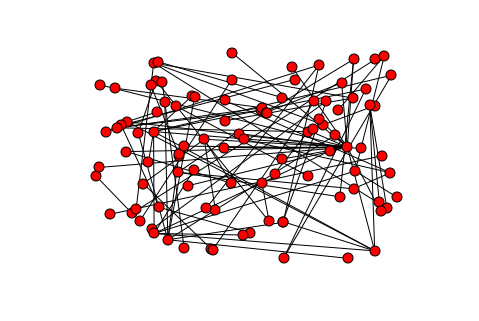

In [78]:
n=100

#On crée une matrice carrée de taille n dont les valeurs sont nulles
M=np.array([[0 for i in range(n)] for j in range(n)])

#On associe à chaque noeud i du réseau un nombre Ai distribué selon une loi de pareto
a, m=2, 1
F=np.around(np.random.pareto(a, n)+m)

#on crée une liste composée de Ai fois chaque entier i
L=list()
for i in range(n):
    L.append([i for el in range(int(F[i]))])
L=list(chain(*L))

#tirage aléatoire de paires sans remise jusqu'à épuisement du stock. A chaque fois que je tire une paire (i,j)
#je crée un edge entre les points i et j

while len(L)>1:
    s0=int(np.around(np.random.uniform(0, len(L)-1, 1)))
    Ls0=L[s0]
    L.remove(L[s0])
    
    s1=int(np.around(np.random.uniform(0, len(L)-1, 1)))
    Ls1=L[s1]
    L.remove(L[s1])
    
    M[Ls0, Ls1]+=1
    M[Ls1, Ls0]+=1

#on supprime les liens multiples et circulaires
M[M>1]==1
for i in range(n):
    M[i, i]=0
    
G=nx.from_numpy_matrix(M)
nx.draw_random(G, node_size=100)

 

In [5]:
#Verifions que le degré suit une loi de pareto
degdist=pd.DataFrame()
degdist['degree']=(nx.degree(G).values())
degdist['rank']=n-degdist['degree'].rank(method='first', ascending=True)
degdist['log_degree']=np.log(degdist['degree'])
degdist['log_rank']=np.log(degdist['rank'])

In [4]:
a

2

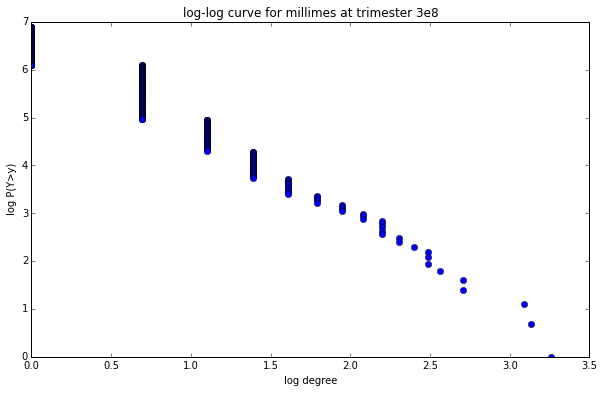

In [11]:
fig = plt.figure(figsize=(10,6))
plt.title("Log-log curves for the degree distribution")

ax=plt.subplot(1,1,1)
ax.set_title("log-log curve for millimes at trimester %x" %(i+1))
plt.ylabel("log P(Y>y)")
plt.xlabel("log degree")
ax.plot(degdist['log_degree'],degdist['log_rank'], 'bo')

plt.show()

In [9]:
degrees  = G.degree() 
# dictionary node:degree
in_values = (sorted(set(degrees.values())) )
in_hist = ([list(degrees.values()).count(x) for x in in_values])
in_hist = n-np.cumsum(in_hist)

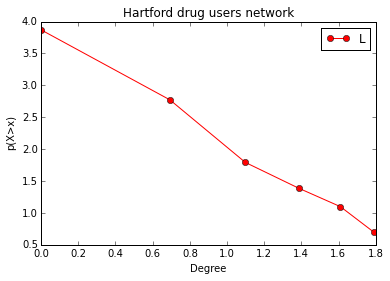

In [10]:
plt.figure()
plt.plot(np.log(in_values),np.log(in_hist),'ro-') 

# out-degree
plt.legend('Log-degree')
plt.xlabel('Degree')
plt.ylabel('p(X>x)')
plt.title('Hartford drug users network')
plt.show()
plt.close()

In [13]:
M

array([[0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [140]:
# - trier en fonction du second élément du t-uple
# - supprimer les doublons en regard du premier élément

import pandas as pd

def supertri(d):
    t,i=d.columns
    d.sort(columns=t, inplace=True) 
    d=d.drop_duplicates(subset=i, take_last=False)
    return(d)

def next_step(d):
    n=d.shape[0]
    t,i=d.columns
    d=supertri(d)
    d.index = range(1,len(d) + 1)
    x=d.copy().loc[1]
    d[t]=d[t]-d[t][1]
    if n==1:
        d= pd.DataFrame(columns=["T","ind"])
    else:
        d=d.loc[2:]
    return([x, d])

d=pd.DataFrame([(6,2), (1, 1), (2, 3), (3, 3), (3, 4)],columns=["T","ind"])
supertri(d) 
next_step(d)[1].shape

(0, 2)

In [150]:
import random
lamb=4

i_0=random.randint(0, n)
i_0=5
V_0= np.array([0] * (i_0-1) + [1] + [0] * (n-i_0))
V_0
States=["S"] * (i_0-1) + ["I"] + ["S"] * (n-i_0)
I=3

H_i = np.dot(V_0, M)
ind_i=[i for i in range(n) if H_i[i]==1]
n_i=np.sum(H_i)
T_i=[random.expovariate(1/lamb) for i in range(n_i)]

new_times=[[T_i[i],ind_i[i]] for i in range(n_i) if I>T_i[i]]
times=pd.DataFrame(new_times,columns=["T","ind"])


times=supertri(times)
i=0
while times.shape[0] != 0:
    i=i+1
    print(i)
##if True:    
    new_step=next_step(times)
    new_ind=int(new_step[0]["ind"])
    new_time=new_step[0]["T"]
    times=new_step[1]
    States[new_ind]="I"
    
    ##On trouve les nouveaux amis potentiellement infectable et on tire un nouveau I:
    I=3
    V_0= np.array([0] * (new_ind-1) + [1] + [0] * (n-new_ind))
    H_i = np.dot(V_0, M)
    
    ## On checque que les potentiellement infectable puisse etre infecter    
    ind_i=[i for i in range(n) if (H_i[i]==1 and States[i]=="S")]
    
    ##On tire des temps pour ces amis
    n_i=len(ind_i)
    T_i=[random.expovariate(1/lamb) for i in range(n_i)]
   
    ##On ne garde que ceux qui sont inférieurs à I
    new_times=[[T_i[i],ind_i[i]] for i in range(n_i) if I>T_i[i]]
    if len(new_times)!=0:
        new_times=pd.DataFrame(new_times,columns=["T","ind"])

        ##On les rajoute à times que l'on update par la suite.
        times=pd.concat([times,new_times])
    
    ##On met à jour
        times=supertri(times)

sum([1 for st in States if st!="S"])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


24